In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
sys.path.append('/global/u2/t/tvnguyen/sbi_stream')
import pickle

import corner
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import astropy.constants as const
import astropy.units as u
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

import datasets
from sbi.utils import BoxUniform
from sbi_stream import infer_utils
from sbi_stream.npe import NPE

%matplotlib inline
plt.style.use('default.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_val_loss(chkpt_path):
    fname = os.path.basename(chkpt_path)
    try:
        val_loss_str = fname.split('val_loss=')[-1].split('.ckpt')[0]
        return float(val_loss_str)
    except Exception:
        return float('inf')

In [4]:
run_dir = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/trained-models/'
run_names = [
    'best-tarp/spline-sf1-2d-large-nodensity',
    'best-tarp/spline-sf1-3d-large-nodensity',
    'best-tarp/spline-sf1-5d-large-nodensity',
    'best-tarp/spline-sf1-6d-large-nodensity',
]
checkpoints = [None, None, None, None]

models = []
for run_name, checkpoint in zip(run_names, checkpoints):
    features = ['phi1', 'phi2', 'pm1', 'pm2', 'vr', 'dist']
    labels = ['log_M_sat', 'log_rs_sat', 'vz', 'vphi', 'r', 'phi']

    # find the best checkpoint based on validation loss if None
    if checkpoint is None:
        checkpoint_paths = glob.glob(
            os.path.join(run_dir, run_name, 'lightning_logs/checkpoints/*.ckpt'))
        checkpoint_list = sorted(glob.glob(os.path.join(run_dir, run_name, 'lightning_logs/checkpoints/*.ckpt')))
        best_checkpoint = min(checkpoint_list, key=get_val_loss)
        checkpoint = os.path.basename(best_checkpoint)
    checkpoint_path = os.path.join(
        run_dir, run_name, 'lightning_logs/checkpoints/', checkpoint)

    print(f"Using checkpoint {checkpoint} for run {run_name}")

    # read in the dataset and run on the validation dataset
    # device = torch.device('cpu')
    device = torch.device('cuda')
    model = NPE.load_from_checkpoint(checkpoint_path, map_location=device)
    models.append(model.eval())

Using checkpoint epoch=709-step=374880-train_loss=-8.3681-val_loss=-8.0632.ckpt for run best-tarp/spline-sf1-2d-large-nodensity
Using checkpoint epoch=409-step=216480-train_loss=-8.7500-val_loss=-8.9960.ckpt for run best-tarp/spline-sf1-3d-large-nodensity
Using checkpoint epoch=1269-step=670560-train_loss=-11.5053-val_loss=-11.1585.ckpt for run best-tarp/spline-sf1-5d-large-nodensity
Using checkpoint epoch=1370-step=723888-train_loss=-11.8287-val_loss=-11.2600.ckpt for run best-tarp/spline-sf1-6d-large-nodensity


In [ ]:
run_dir = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/trained-models/'
run_names = [
    'best-tarp/spline-sf1-2d-large-nodensity',
    'best-tarp/spline-sf1-3d-large-nodensity',
    'best-tarp/spline-sf1-5d-large-nodensity',
    'best-tarp/spline-sf1-6d-large-nodensity',
]
checkpoints = [None, None, None, None]

models = []
for run_name, checkpoint in zip(run_names, checkpoints):
    features = ['phi1', 'phi2', 'pm1', 'pm2', 'vr', 'dist']
    labels = ['log_M_sat', 'log_rs_sat', 'vz', 'vphi', 'r', 'phi']

    # find the best checkpoint based on validation loss if None
    if checkpoint is None:
        checkpoint_paths = glob.glob(
            os.path.join(run_dir, run_name, 'lightning_logs/checkpoints/*.ckpt'))
        checkpoint_list = sorted(glob.glob(os.path.join(run_dir, run_name, 'lightning_logs/checkpoints/*.ckpt')))
        best_checkpoint = min(checkpoint_list, key=get_val_loss)
        checkpoint = os.path.basename(best_checkpoint)
    checkpoint_path = os.path.join(
        run_dir, run_name, 'lightning_logs/checkpoints/', checkpoint)

    print(f"Using checkpoint {checkpoint} for run {run_name}")

    # read in the dataset and run on the validation dataset
    # device = torch.device('cpu')
    device = torch.device('cuda')
    model = NPE.load_from_checkpoint(checkpoint_path, map_location=device)
    models.append(model.eval())

Using checkpoint epoch=709-step=374880-train_loss=-8.3681-val_loss=-8.0632.ckpt for run best-tarp/spline-sf1-2d-large-nodensity
Using checkpoint epoch=409-step=216480-train_loss=-8.7500-val_loss=-8.9960.ckpt for run best-tarp/spline-sf1-3d-large-nodensity
Using checkpoint epoch=1269-step=670560-train_loss=-11.5053-val_loss=-11.1585.ckpt for run best-tarp/spline-sf1-5d-large-nodensity
Using checkpoint epoch=1370-step=723888-train_loss=-11.8287-val_loss=-11.2600.ckpt for run best-tarp/spline-sf1-6d-large-nodensity


In [5]:
data_root = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/preprocessed_datasets/AAU'
data_names = [
   '2d-AAU-spline-sf1',
   '3d-AAU-spline-sf1',
   '5d-AAU-spline-sf1',
   '6d-AAU-spline-sf1',
]

In [6]:
pl.seed_everything(32191)

all_samples = []
all_truths = []
all_logprobs = []

for model, data_name in zip(models, data_names):
   norm_dict = model.norm_dict

   x, y, t, padding_mask = datasets.read_processed_datasets(
      os.path.join(data_root, data_name),
      num_datasets=1,
      start_dataset=0,
   )
   x_loc = norm_dict["x_loc"]
   x_scale = norm_dict["x_scale"]
   y_loc = norm_dict["y_loc"]
   y_scale = norm_dict["y_scale"]
   t_loc = norm_dict["t_loc"]
   t_scale = norm_dict["t_scale"]
   x_norm = (x - x_loc) / x_scale
   y_norm = (y - y_loc) / y_scale
   t_norm = (t - t_loc) / t_scale

   # convert to tensors
   x_norm = torch.tensor(x_norm, dtype=torch.float32)
   y_norm = torch.tensor(y_norm, dtype=torch.float32)
   t_norm = torch.tensor(t_norm, dtype=torch.float32)
   padding_mask = torch.tensor(padding_mask, dtype=torch.bool)

   # data loader
   data_loader = DataLoader(TensorDataset(x_norm, y_norm, t_norm, padding_mask))

   prior_min = [-4, -1, -100, -100, 0, 0, ]
   prior_max = [-2, 0, 100, 100, 3, 360]
   prior_min = torch.tensor(prior_min, dtype=torch.float32)
   prior_max = torch.tensor(prior_max, dtype=torch.float32)
   prior = BoxUniform(
      low=prior_min, high=prior_max, device=torch.device('cpu'))

   samples, truths, log_probs = infer_utils.sample(
      model, data_loader, 100_000, norm_dict=model.norm_dict, return_log_probs=True)
   samples = samples.squeeze()
   truths = truths.squeeze()
   log_probs = log_probs.squeeze()

   prior_logprob = prior.log_prob(samples)
   mask = ~torch.isinf(prior_logprob)
   samples = samples[mask]
   log_probs = log_probs[mask]

   samples = samples.numpy()
   truths = truths.numpy()
   log_probs = log_probs.numpy()

   all_samples.append(samples)
   all_truths.append(truths)
   all_logprobs.append(log_probs)

Seed set to 32191
Sampling:   0%|          | 0/1 [00:00<?, ?it/s]/global/homes/t/tvnguyen/.conda/envs/torch-py11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647348947/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Sampling: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


In [7]:
# do some conversion
all_samples2 = []
all_truths2 = []

for samples, truths in zip(all_samples, all_truths):
    samples2 = np.zeros((samples.shape[0], 6))
    samples2[:, 0] = 10**(samples[:, 0] + 3)  # M_sat
    samples2[:, 1] = 10**samples[:, 1]  # r_sat
    samples2[:, 2] = np.sqrt(samples[:, 2]**2 + samples[:, 3]**2)
    samples2[:, 3] = samples[:, 3]  # vz
    samples2[:, 4] = samples[:, 4]
    samples2[:, 5] = samples[:, 5]
    all_samples2.append(samples2)

    truths2 = np.zeros((truths.shape[0], 6))
    truths2[:, 0] = 10**(truths[0] + 3)
    truths2[:, 1] = 10**truths[1]
    truths2[:, 2] = np.sqrt(truths[2]**2 + truths[3]**2)
    truths2[:, 3] = truths[3]  # vz
    truths2[:, 4] = truths[4]
    truths2[:, 5] = truths[5]
    all_truths2.append(truths2)

### Plot

In [8]:
def rgb_to_hex(rgb):
    """Convert RGB tuple (0-1 values) to hex color string."""
    r, g, b = rgb
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

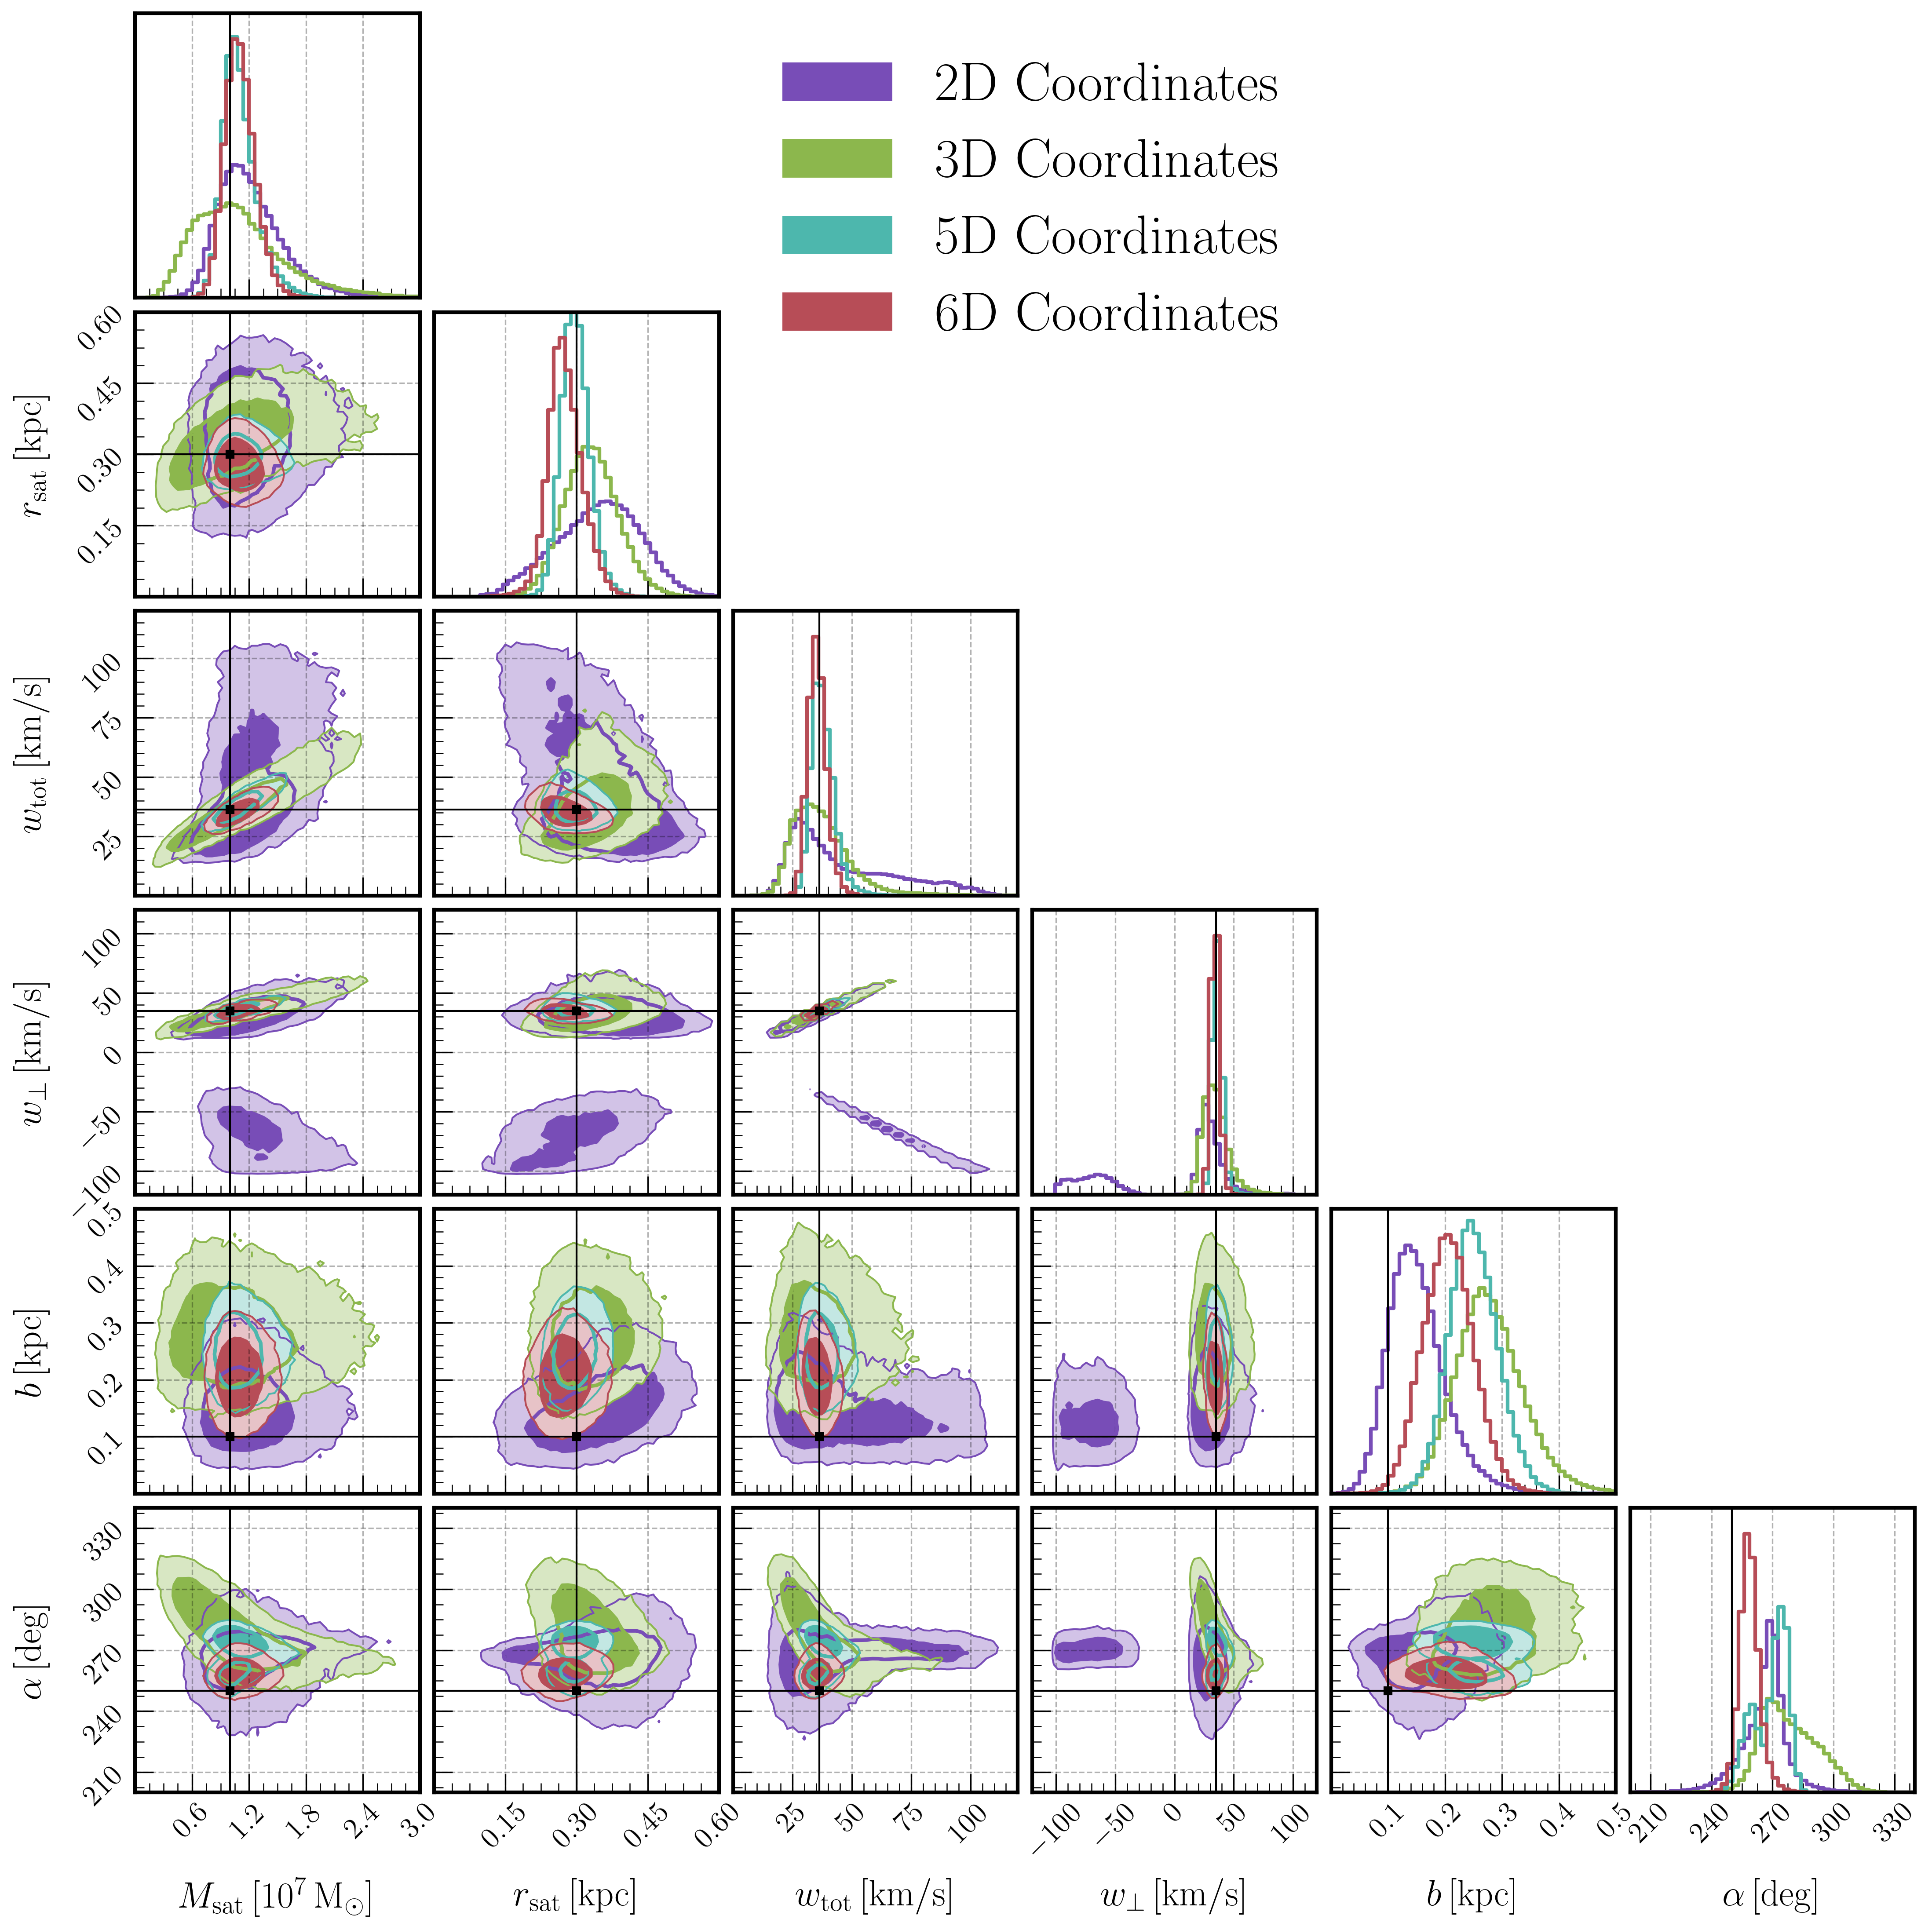

In [16]:
indices = [0, 1, 2, 3, 4, 5]  # Msat, vtotal, vperp, alpha
n_params = len(indices)
# orders = [3, 2, 1, 0]
orders = [0, 1, 2, 3]

# Corner plot with Msat, vtotal, and vperp
fig, axes = plt.subplots(n_params, n_params, figsize=(15, 15), dpi=300)

# colors = [
#     "#780086",
#     "#00ad05",
#     "#f540b6",
#     "#a21a27"
# ]

colors = [
    "#784db7",
    "#8cb74d",
    "#4db7ad",
    "#b74d57"
]

# colors = sns.color_palette("tab10", n_colors=4)
# colors = [rgb_to_hex(colors[i]) for i in range(len(colors))]

labels = [
    r'$M_\mathrm{sat} \, [10^7 \,\mathrm{M}_\odot]$',
    r'$r_\mathrm{sat} \, [\mathrm{kpc}]$',
    r'$w_\mathrm{tot} \, [\mathrm{km/s}]$',
    r'$w_\mathrm{\perp} \, [\mathrm{km/s}]$',
    r'$b \, [\mathrm{kpc}]$',
    r'$\alpha \, [\mathrm{deg}]$',
]
plot_range = [
    [0., 3],
    [0.0, 0.6],
    [0, 120],
    [-120, 120],
    [0, 0.5],
    [200, 340],
]
smooth = 0
smooth1d = 0
bins = 50

# plot 2D first since it's the widest
for i in orders:
    array = all_samples2[i][:, indices]
    fig = corner.corner(
        array,
        color=colors[i],
        contour_kwargs=dict(linestyles=["solid", "solid"], linewidths=[1, 2]),
        levels=(0.68, 0.95, ),
        show_titles=False,
        label_kwargs=dict(fontsize=20),
        labels=labels,
        plot_contours=True,
        plot_datapoints=False,
        plot_density=False,
        fill_contours=True,
        bins=bins,
        hist_bin_factor=1,
        smooth=smooth,
        smooth1d=smooth1d,
        range=plot_range,
        fig=fig,
        hist_kwargs=dict(
            linewidth=2,
            alpha=1,
        ),
    )

# plot the truth values manually
truth = all_truths2[i][0, indices]
truth_color = 'k'

# Add vertical lines on diagonal plots (histograms)
for i in range(n_params):
    ax = axes.ravel()[i * (n_params + 1)]  # Diagonal elements
    ax.axvline(truth[i], color=truth_color, linestyle='-', linewidth=1)

# Add lines on off-diagonal plots
for i in range(n_params):
    for j in range(i):
        ax = axes.ravel()[i * n_params + j]
        ax.axvline(truth[j], color=truth_color, linestyle='-', linewidth=1, alpha=1)
        ax.axhline(truth[i], color=truth_color, linestyle='-', linewidth=1, alpha=1)
        ax.plot(truth[j], truth[i], truth_color + 's', markersize=4, alpha=1)

# set axis limit
for i in range(n_params):
    for j in range(n_params):
        ax = axes[i, j]
        if i == j:  # Diagonal elements
            ax.set_xlim(plot_range[i])
        else:
            ax.set_xlim(plot_range[j])
            ax.set_ylim(plot_range[i])

legend_elements = []
labels = [
    '2D Coordinates',
    '3D Coordinates',
    '5D Coordinates',
    '6D Coordinates',
]
for i in range(4):
    legend_elements.append(Patch(facecolor=colors[i],label=labels[i]))

# Add legend to the figure
axes.ravel()[2].legend(
    handles=legend_elements, loc='upper left',
    # bbox_to_anchor=(0.7, 0.98),
    fontsize=30,
    frameon=False,
)
# fig.tight_layout()
fig.savefig('figures/corner6d_obs_mv.pdf', bbox_inches='tight', dpi=300)

In [17]:
def compute_hpd_and_map(samples, log_probs, credible_level=0.95):
    # Convert log probabilities to probabilities
    probs = np.exp(log_probs)

    # Normalize probabilities to sum to 1
    probs = probs / np.sum(probs)

    # Find the MAP (maximum a posteriori)
    map_idx = np.argmax(probs)
    map_value = samples[map_idx]

    # Sort samples by probability (descending)
    sorted_indices = np.argsort(-probs)
    sorted_samples = samples[sorted_indices]
    sorted_probs = probs[sorted_indices]

    # Calculate cumulative probabilities
    cumulative_probs = np.nancumsum(sorted_probs)

    # Find all samples within the credible_level
    indices = np.where(cumulative_probs <= credible_level)[0]

    # print(indices)

    # If no samples fall exactly at the boundary, include one more
    if len(indices) < len(samples) and indices[-1] < len(sorted_samples) - 1:
        indices = np.append(indices, indices[-1] + 1)

    # Get the highest posterior density interval
    hpd_samples = sorted_samples[indices]

    # Find the lower and upper bounds
    hpd_lower = np.nanmin(hpd_samples)
    hpd_upper = np.nanmax(hpd_samples)

    return map_value, (hpd_lower, hpd_upper)

In [19]:
import arviz

In [20]:
for i in range(len(all_samples)):
    samples = all_samples2[i]

    for j in range(samples.shape[1]):
        # hdi = arviz.hdi(samples[..., j], hdi_prob=0.68, multimodal=False)
        median = np.median(samples[..., j])        # print(hdi, map_value)
        hdi = np.quantile(samples[..., j], [0.16, 0.84])
        print('{:.2f} +{:.2f} - {:.2f}'.format(median, hdi[1] - median, median - hdi[0]))

    print('---')

1.17 +0.38 - 0.27
0.35 +0.08 - 0.10
39.12 +34.16 - 13.07
24.18 +12.22 - 94.85
0.15 +0.05 - 0.04
267.72 +6.74 - 11.88
---
1.03 +0.52 - 0.39
0.33 +0.06 - 0.05
35.50 +12.34 - 9.40
33.78 +10.70 - 8.80
0.28 +0.06 - 0.05
276.55 +17.04 - 11.66
---
1.08 +0.20 - 0.14
0.30 +0.03 - 0.03
37.27 +5.20 - 3.91
35.57 +4.39 - 3.47
0.25 +0.04 - 0.04
271.36 +5.66 - 12.65
---
1.10 +0.17 - 0.15
0.27 +0.04 - 0.03
35.33 +3.93 - 3.58
34.22 +3.46 - 3.34
0.21 +0.04 - 0.04
258.48 +4.86 - 4.39
---


In [13]:
for i in range(len(all_samples)):
    samples = all_samples[i]

    median = np.median(samples[..., 2])        # print(hdi, map_value)
    hdi = np.quantile(samples[..., 2], [0.16, 0.84])
    print('{:.2f} +{:.2f} - {:.2f}'.format(median, hdi[1] - median, median - hdi[0]))

    print('---')

-9.58 +11.96 - 9.03
---
-10.72 +3.87 - 7.19
---
-11.16 +2.75 - 3.55
---
-8.72 +1.86 - 2.56
---
